<a href="https://colab.research.google.com/github/2303a51512/1512_python-for-data-science/blob/main/supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Loaded Successfully ✅
Dataset Shape: (23658, 38)
    Patient_ID  Age  Gender Smoking_History  Tumor_Size_mm Tumor_Location  \
0  Patient0000   68    Male  Current Smoker      81.678677     Lower Lobe   
1  Patient0001   58    Male    Never Smoked      78.448272     Lower Lobe   
2  Patient0002   44    Male   Former Smoker      67.714305     Lower Lobe   
3  Patient0003   72    Male  Current Smoker      70.806008     Lower Lobe   
4  Patient0004   37  Female    Never Smoked      87.272433     Lower Lobe   

       Stage          Treatment  Survival_Months         Ethnicity  ...  \
0  Stage III            Surgery               44          Hispanic  ...   
1    Stage I  Radiation Therapy              101         Caucasian  ...   
2    Stage I       Chemotherapy               69  African American  ...   
3  Stage III       Chemotherapy               95  African American  ...   
4   Stage IV  Radiation Therapy              105             Asian  ...   

  Alanine_Aminotransferase_Level

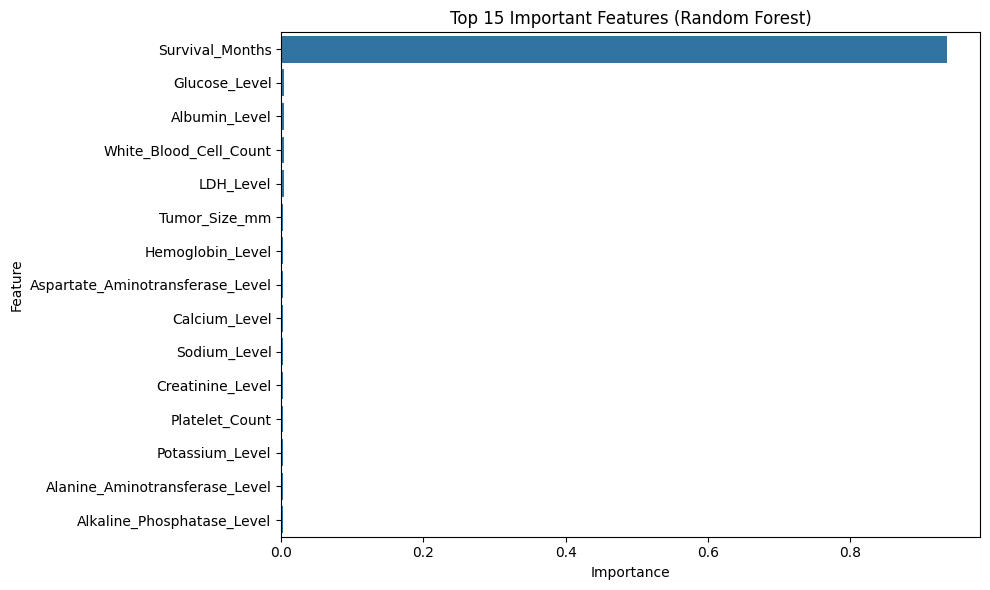


Analysis Complete ✅


In [2]:
# ==========================
# Lung Cancer Survival Prediction & Treatment Analysis
# ==========================
# Author: Soumyasri Vaidugula
# Problem: Predict lung cancer survival outcomes using supervised ML algorithms
# Dataset: Synthetic lung cancer dataset
# ==========================

# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# --- Load Dataset ---
df = pd.read_csv("lung_cancer_data.csv")   # Update if path differs
print("Data Loaded Successfully ✅")
print(f"Dataset Shape: {df.shape}")
print(df.head())

# --- Basic Preprocessing ---
# Drop unique ID or irrelevant columns
if 'Patient_ID' in df.columns:
    df.drop(columns=['Patient_ID'], inplace=True)

# Identify initial target variable, primarily 'Survival_Months' or 'Survival_Status'
initial_target_col = None
if 'Survival_Months' in df.columns:
    initial_target_col = 'Survival_Months'
elif 'Survival_Status' in df.columns:
    initial_target_col = 'Survival_Status'
else:
    # fallback option (if column name differs)
    possible_targets = [c for c in df.columns if 'surviv' in c.lower()]
    if possible_targets:
        initial_target_col = possible_targets[0]
    else:
        raise ValueError("⚠️ Target column not found! Please verify survival status column name.")

print(f"Initial Target Column identified: {initial_target_col}")

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna("Unknown", inplace=True)

# Create a binary target 'Survival_Status_12m' from 'Survival_Months' if applicable
# Assuming 12 months is a relevant threshold for binary classification
target_col_final = initial_target_col
if initial_target_col == 'Survival_Months':
    df['Survival_Status_12m'] = (pd.to_numeric(df['Survival_Months'], errors='coerce') >= 12).astype(int)
    target_col_final = 'Survival_Status_12m'
    print(f"Created binary target '{target_col_final}' based on Survival_Months >= 12.")
elif initial_target_col == 'Survival_Status':
    # If 'Survival_Status' exists, it might already be binary (e.g., 'Alive', 'Dead')
    # We'll let LabelEncoder handle it if it's categorical below.
    pass

print(f"Final Target Column for modeling: {target_col_final}")

# Separate features and target
X = df.drop(columns=[target_col_final])
y = df[target_col_final]

# Encode categorical variables for features (X)
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode target (y) - only if it's categorical (e.g., 'Alive'/'Dead' strings)
# If it's already 0/1 integers (from 'Survival_Status_12m'), this block will be skipped.
if y.dtype == 'object' or y.dtype.name == 'category':
    y = LabelEncoder().fit_transform(y)

# Scale numeric features
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)

# --- Split Dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training Size: {X_train.shape}, Test Size: {X_test.shape}")

# --- Define Models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# --- Train and Evaluate Models ---
results = []

for name, model in models.items():
    print(f"\n==============================")
    print(f"Training Model: {name}")
    print(f"==============================")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Ensure y_prob is available for AUC; some models might not have predict_proba
    y_prob = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    # roc_auc_score requires binary target, which is now ensured by the preprocessing step
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    results.append({"Model": name, "Accuracy": acc, "ROC-AUC": auc})

# --- Summary Table ---
result_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\n===== Model Comparison Summary ====")
print(result_df)

# --- Feature Importance (Random Forest Example) ---
rf = models["Random Forest"]
importances = rf.feature_importances_
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(15), x="Importance", y="Feature")
plt.title("Top 15 Important Features (Random Forest)")
plt.tight_layout()
plt.show()

print("\nAnalysis Complete ✅")